In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp 
import scipy.sparse as sps
import scipy.optimize as optimization
#import seaborn as sns

%matplotlib inline
#%matplotlib notebook

In [2]:
L = 256
J = 1.
k = 1

PBC = False
p = 0

In [3]:
TL = sps.csr_matrix(np.array([[1,0],[0,0]]))
TR = sps.csr_matrix(np.array([[0,1],[0,0]]))
BR = sps.csr_matrix(np.array([[0,0],[0,1]]))

def build_AB(h, PBC, p):
    A = sps.dok_matrix((L, L), dtype=np.float32)
    B = sps.dok_matrix((L, L), dtype=np.float32)
    
    A.setdiag(h)
    A.setdiag(-J/2, k=1)
    A.setdiag(-J/2, k=-1)
    
    B.setdiag(-k*J/2, k=1)
    B.setdiag(k*J/2, k=-1)
    
    if PBC:
        A[0,-1] = (-1)**p*J/2
        A[-1,0] = (-1)**p*J/2
        
        B[0,-1] = -(-1)**p*k*J/2
        B[-1,0] = (-1)**p*k*J/2
    
    return A,B

def build_Hmat(h, PBC, p):
    A, B = build_AB(h, PBC, p)
    
    H = sps.kron(TL,A)
    H += sps.kron(BR,-A.conjugate())
    H += sps.kron(TR,B)
    H += sps.kron(TR.transpose(),-B.conjugate())
    
    return H

######################################

def spectrum(h, PBC, p):
    H = build_Hmat(h, PBC, p)
    eig = sp.linalg.eigvalsh(H.toarray())
    return eig

######################################

def orthogonalize(E, V):
    if not np.any(np.abs(E)<1e-6):
        return E, V
    
    indx = np.argwhere(np.abs(E)<1e-6).flatten()
    if len(indx)!=2: #check eigenspace_dimension=2
        raise ValueError(f"Wrong number of zero eigenvalues: {len(indx)}")
    u,v = clean_eigenv(V[:,indx[0]], V[:,indx[1]])
    V[:,indx[0]], V[:,indx[1]] = u, v
    return E, V

def clean_eigenv(w1, w2):
    a = S@(w1+w2) + (w1+w2)
    b = S@(w1-w2) - (w1-w2)
    a /= np.linalg.norm(a)
    b /= np.linalg.norm(b)
    
    u = (a + b)
    v = (a - b)
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)
    return u, v

def Diagonalize(h, PBC, p):
    # Build Hmat
    H = build_Hmat(h, PBC, p)
    # Diagonalize
    e, v = sp.linalg.eigh(H.toarray())
    # Orthogonalize zero-energy eigenspace
    return orthogonalize(e,v)
    
    

In [4]:
### Fixed h ###

h_s = np.array([2., 1., 0.5])

E = np.ndarray((len(h_s), 2*L))

for i,h in enumerate(h_s):
    e = spectrum(h, PBC, p)
    E[i] = np.sort(e)/J

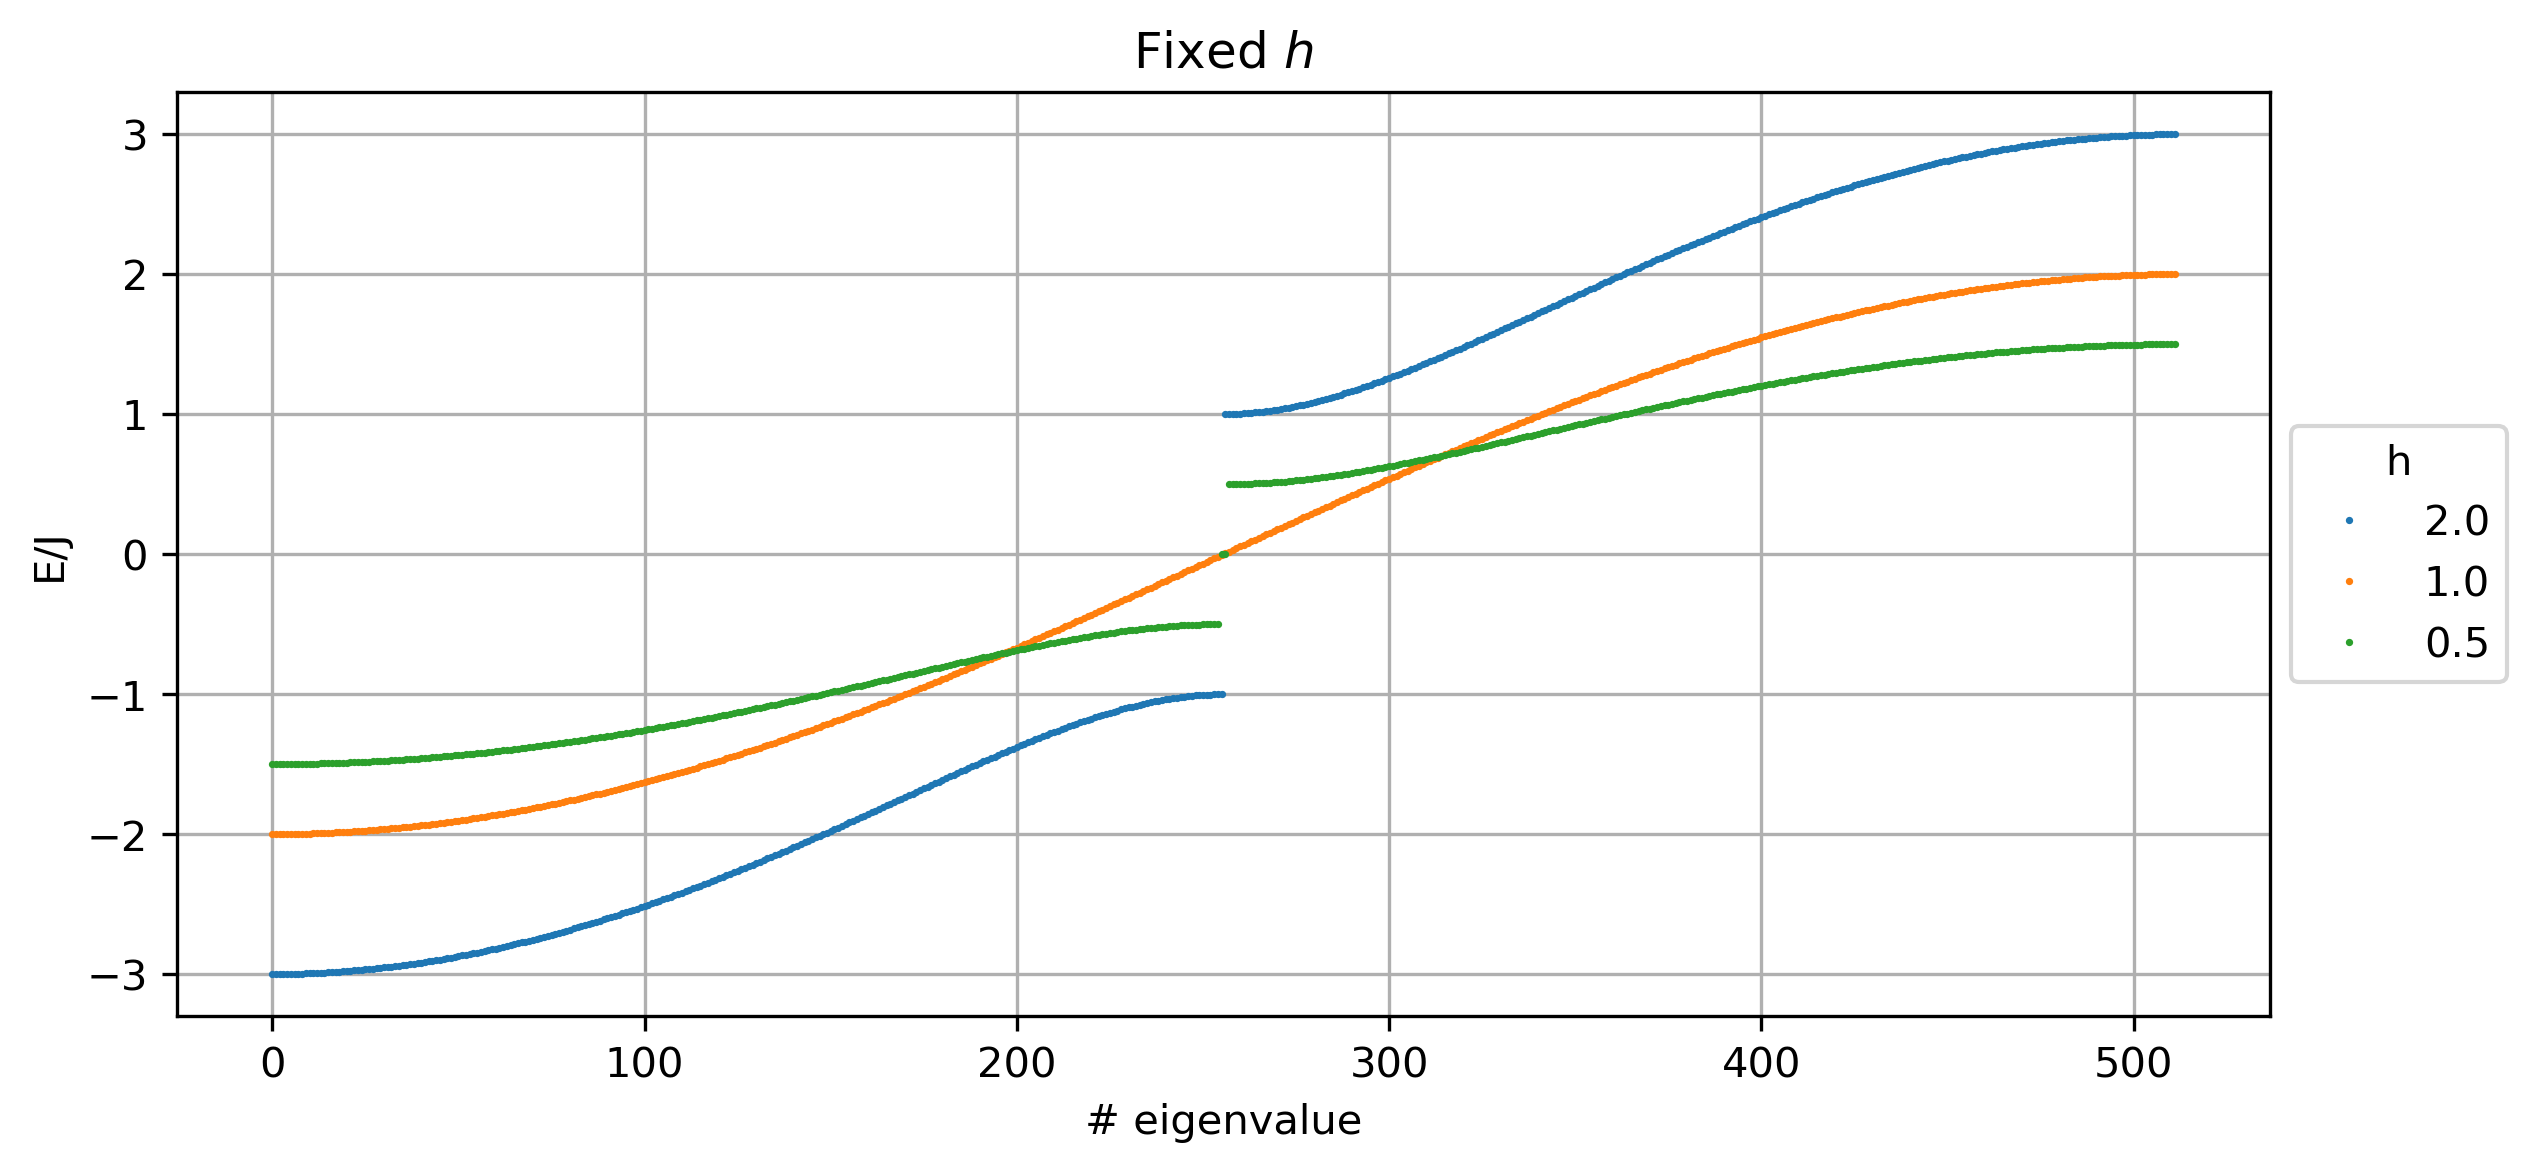

In [5]:
# Plot
fig = plt.figure(figsize=(9, 4), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Fixed $h$")
plt.xlabel(r"# eigenvalue")
plt.ylabel(r"E/J")
for i in range(len(h_s)):
    plt.plot(np.arange(2*L), E[i], ".", markersize = 1.5, label = str(h_s[i]))
plt.grid()
ax.legend(title = "h", loc = "center left", bbox_to_anchor = (1, .5))
plt.show()

In [6]:
### Variable h ###

N_h = 101
h_s = np.linspace(0., 2., N_h)

E = np.ndarray((len(h_s), 2*L))

for i,h in enumerate(h_s):
    e = spectrum(h, PBC, p)
    E[i] = np.sort(e)/J

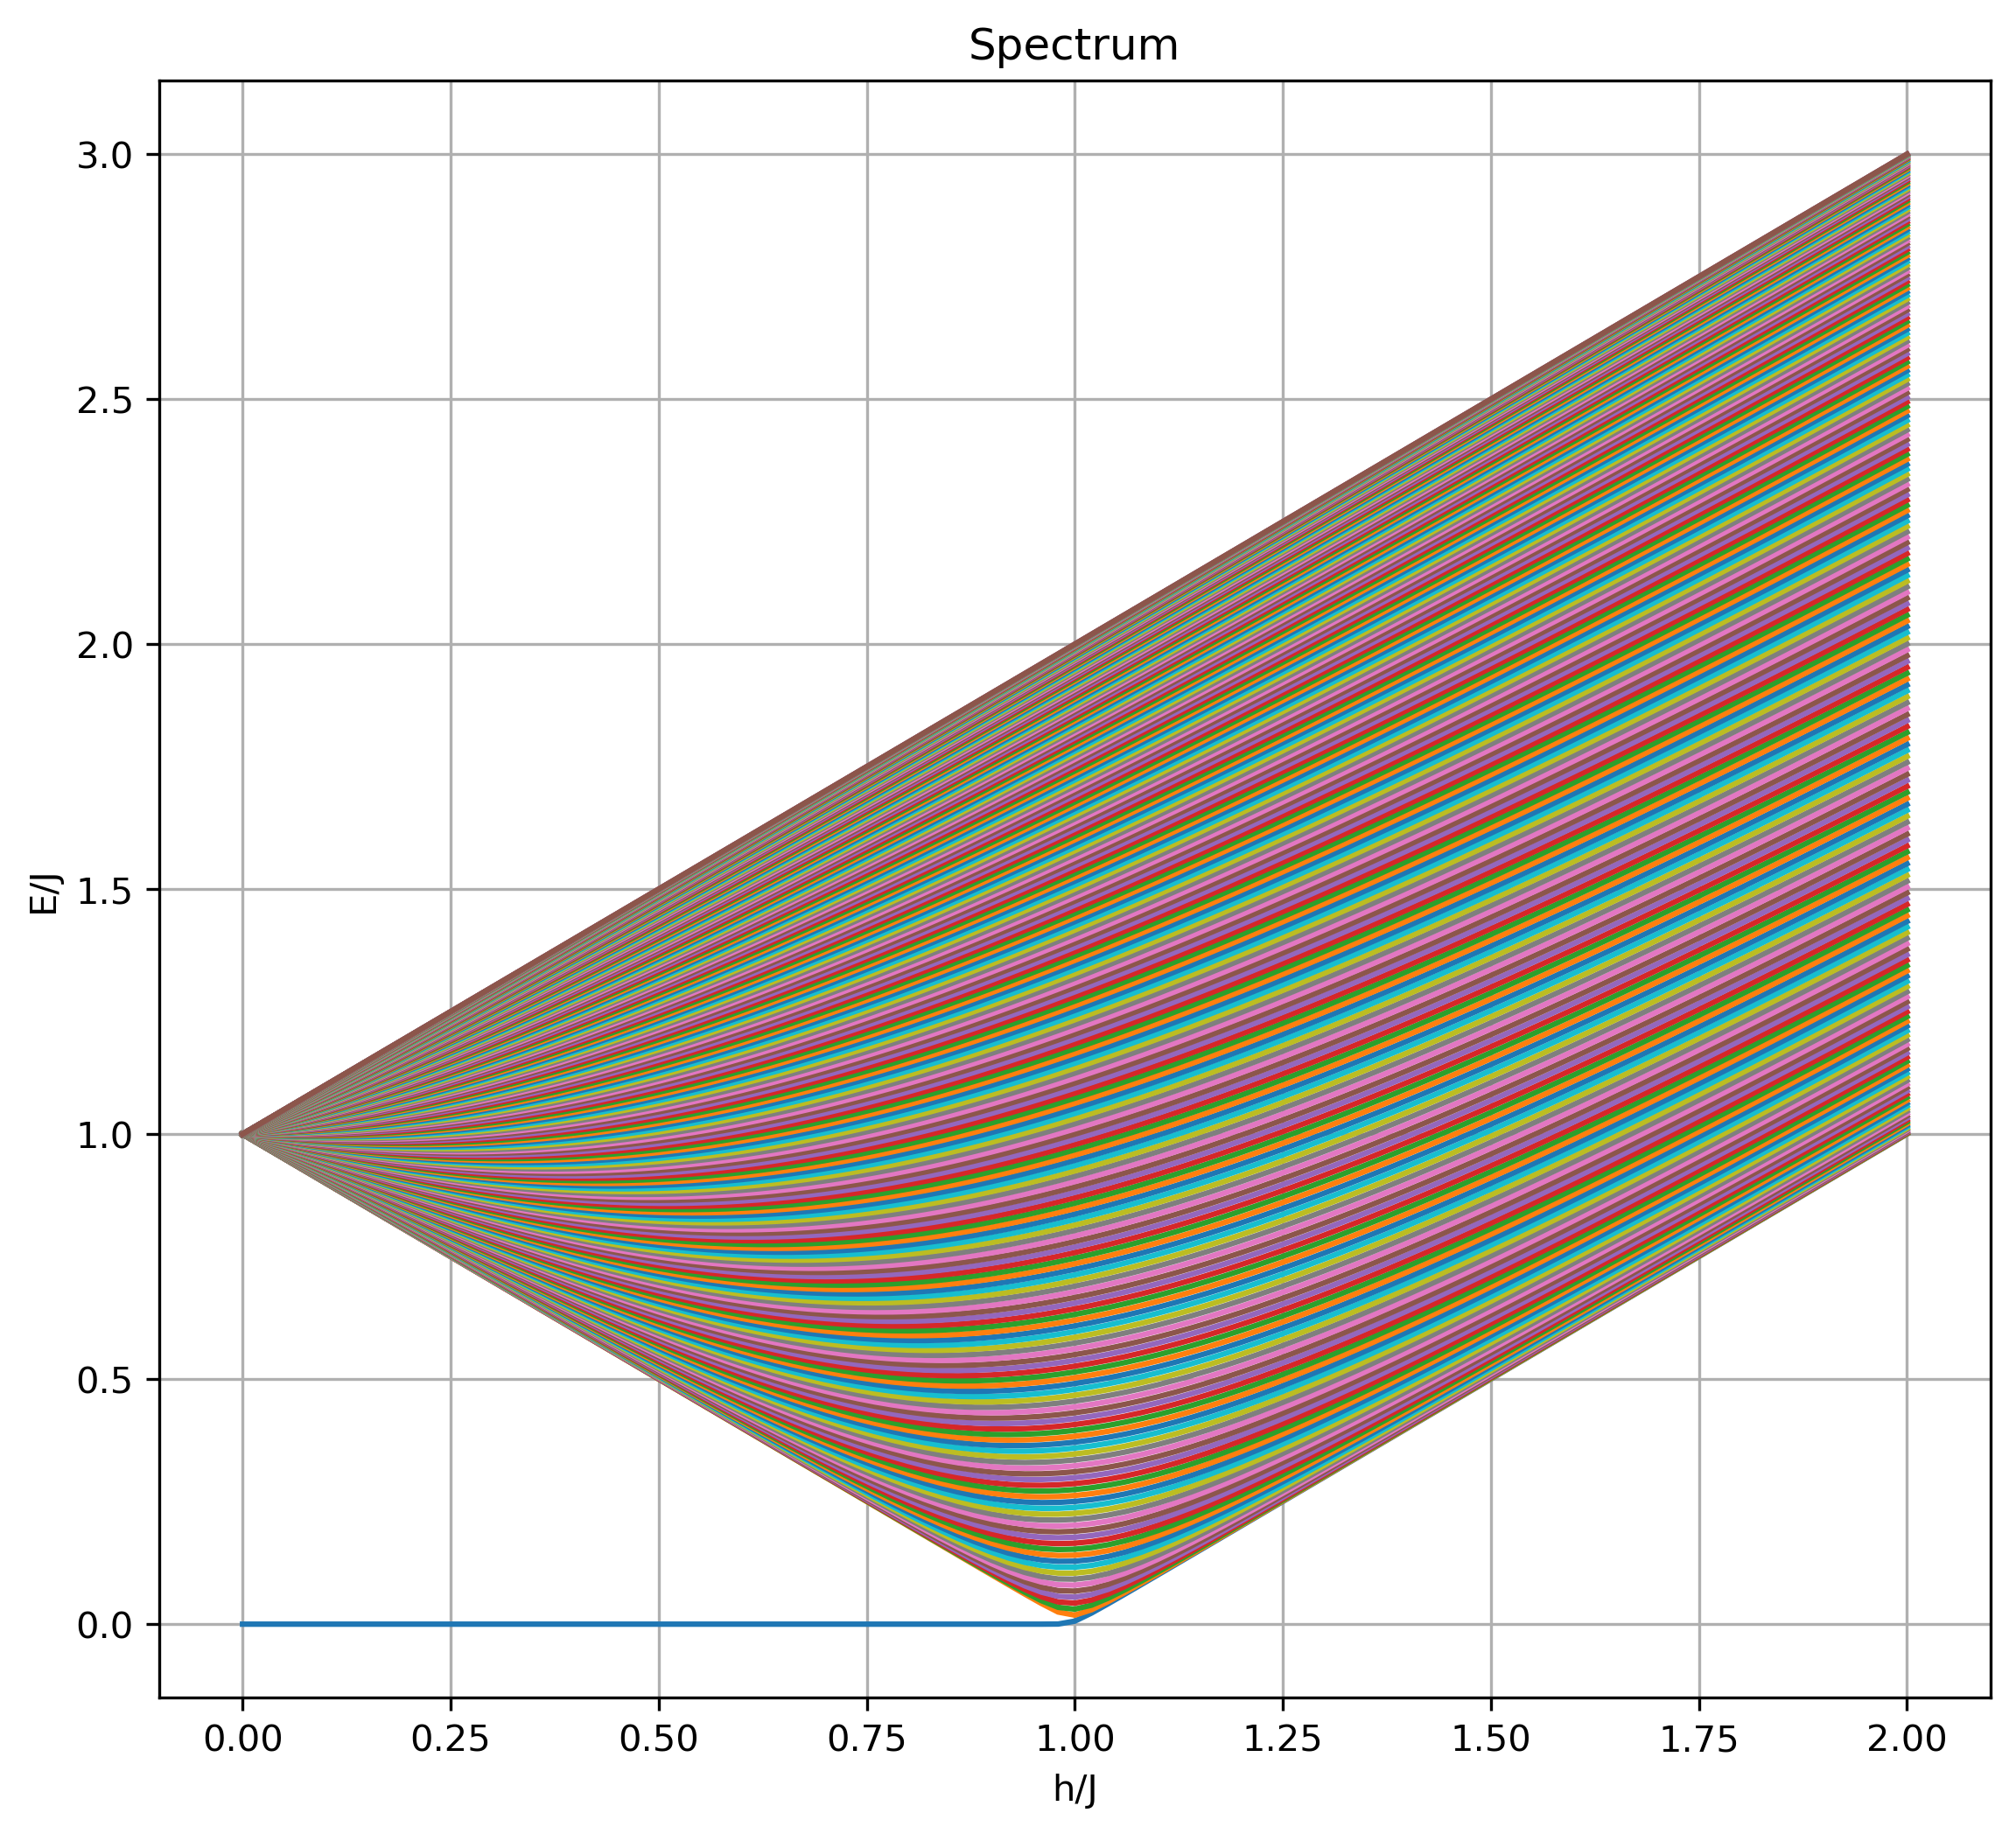

In [7]:
# Plot
fig = plt.figure(figsize=(9, 8), dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.set_title(r"Spectrum")
ax.set_xlabel(r"h/J")
ax.set_ylabel(r"E/J")
plt.grid()
for i in range(L, 2*L):
    plt.plot(h_s/J, E[:,i], "-", markersize = .7)
plt.show()

# Assignment 2

In [8]:
L = 256

In [9]:
# Swap matrices
Id = sps.dok_matrix((L,L))
Id.setdiag(1)
S = sps.kron(sps.csr_matrix(np.array([[0,1],[1,0]])), Id)

In [10]:
h = 0.9

eigval, eigvec = Diagonalize(h, False, 0)

eigval

In [11]:
# Check unitarity
## assume H real => unitarity == orthogonality

check = eigvec@eigvec.transpose()-np.eye(2*L)
if np.any(check>1e-8):
    print("Unitarity not satisfied")
else:
    print("Unitarity checked: ok")

Unitarity checked: ok
